---

# InClass Kaggle Competition
### Nour Azar, Sofie Ghysels, Fernando Delgado

---

The machine learning pipeline includes:

1. Data processing
- Error correction
- Feature engineering
- Value transformation
- Variable selection

2. Modeling
- Logistic Regression, Random Forest, XGBoost, KNN, SVM
- Hyper parameter tuning

3. Experimental setup
- k-fold CV

In [532]:
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Feature engineering step
enable_num_poly = True  # Add polynomial terms

# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = False # Equal Freq Discretization
enable_trans_num_ew = False # Equal Weight Discretization 

#Other
fixpoutcome = True
nofixpoutcome = False


## Initiation

In [533]:
wd = "C:/Users/fdelgado/OneDrive - IESEG/Documents/01. IESEG/13. Statistical and Machine Learning Approaches/Group_Project_Group6"

In [534]:
# Data exploration
import matplotlib.pyplot as plt


# Data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder,  KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
xgb.set_config(verbosity=0) #Fix warning error from xgb

#Scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Experimental setup
from sklearn.model_selection import KFold,  RepeatedStratifiedKFold, cross_validate, GridSearchCV

#Other
import shutup; shutup.please() 


## 1. Data summary

#### (a) Read and print out some data

In [535]:
# Read train, test
train = pd.read_csv(wd + './data/raw/bank_mkt_train.csv', low_memory=False)
test = pd.read_csv(wd + './data/raw/bank_mkt_test.csv', low_memory=False)

In [536]:
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

object     10
float64     9
int64       2
dtype: int64


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [537]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

Wall time: 1 ms


#### (c) Check the target variable class distribution

In [538]:
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64


#### (d) Create a Validation Set

In [539]:
# Set seed
np.random.seed(1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(train[predictors], 
    train[target_var], 
    test_size = 0.2, 
    stratify = train[target_var])

## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [540]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""

# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
X_train = X_train[num_vars + cat_vars]
X_test = X_test[num_vars + cat_vars]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [541]:
# Check missing value
print('Train - # NA of num vars:', X_train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', X_train[cat_vars].isna().sum().sum())
print('Validation - # NA of num vars:', X_test[num_vars].isna().sum().sum())
print('Validation - # NA of cat vars:', X_test[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1391
Train - # NA of cat vars: 1547
Validation - # NA of num vars: 339
Validation - # NA of cat vars: 387
Test - # NA of num vars: 918
Test - # NA of cat vars: 1057


In [542]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""

# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = X_train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = X_train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
X_train = X_train[num_vars + cat_vars]
X_test = X_test[num_vars + cat_vars]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []


#### (c) Fix Categoricals NA

In [543]:
if fixpoutcome:
    #Fix poutcome nonexistent to unknown
    X_train['poutcome'] = np.where(X_train['poutcome'] == 'nonexistent', 'unknown', X_train['poutcome'] )
    X_test['poutcome'] = np.where(X_test['poutcome'] == 'nonexistent', 'unknown', X_test['poutcome'] )
    test['poutcome'] = np.where(test['poutcome'] == 'nonexistent', 'unknown', test['poutcome'] )

    #Fill categoricals with "unknown"
    for c in cat_vars:
        X_train[c].fillna(value='unknown', inplace=True)
        X_test[c].fillna(value='unknown', inplace=True)
        test[c].fillna(value='unknown', inplace=True)     

In [544]:
if nofixpoutcome:
    #Fill categoricals with "unknown"
    for c in cat_vars:
        X_train[c].fillna(value='unknown', inplace=True)
        X_test[c].fillna(value='unknown', inplace=True)
        test[c].fillna(value='unknown', inplace=True)     

#### (d) Fix Numericals NA

In [545]:
#We fix AGE with the mean  
age_mean = X_train['age'].mean()

#Train
X_train['missing_age'] = np.where(X_train['age'].isnull(), 1, 0)
X_train['age'].fillna(value=age_mean, inplace=True)

#Validation
X_test['missing_age'] = np.where(X_test['age'].isnull(), 1, 0)
X_test['age'].fillna(value=age_mean, inplace=True)

#Test
test['missing_age'] = np.where(test['age'].isnull(), 1, 0)
test['age'].fillna(value=age_mean, inplace=True)

In [546]:
#Fill other numericals with mode
# The reasoning behind this is because they are money-related variables, not really continuous variables.

for c in num_vars:
    if X_train[c].isna().sum() > 0:
        mode = X_train[c].mode()[0]
        #Tracking var
        X_train['missing_' + str(c)] = np.where(X_train[c].isnull(), 1, 0)
        X_test['missing_' + str(c)] = np.where(X_test[c].isnull(), 1, 0)
        test['missing_' + str(c)] = np.where(test[c].isnull(), 1, 0)
        #Fill NA
        X_train[c].fillna(value=mode, inplace=True)
        X_test[c].fillna(value=mode, inplace=True)
        test[c].fillna(value=mode, inplace=True)


In [547]:
#remake column list
na_vars = [col for col in X_train.columns if 'missing' in col]

#### (e) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [548]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(X_train[v])
    sd = np.std(X_train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (X_train[v] < lower) | (X_train[v] > upper)
    val_out = (X_test[v] < lower) | (X_test[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(val_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, validation, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(val_out), "[", np.round(100*np.mean(val_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

age has # outliers on train, validation, test : 139 [ 0.87 % ] 42 [ 1.05 % ] 89 [ 0.89 % ]
campaign has # outliers on train, validation, test : 339 [ 2.12 % ] 84 [ 2.1 % ] 210 [ 2.1 % ]
pdays has # outliers on train, validation, test : 584 [ 3.65 % ] 166 [ 4.15 % ] 371 [ 3.71 % ]
previous has # outliers on train, validation, test : 404 [ 2.53 % ] 115 [ 2.88 % ] 269 [ 2.69 % ]
Wall time: 74 ms


#### (f) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [549]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Encode categorical variables as integer values

# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([X_train[cat_vars].astype(str), X_test[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))

# Apply on train, test
X_train[cat_vars] = enc.transform(X_train[cat_vars].astype(str))
X_test[cat_vars] = enc.transform(X_test[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

#### (g) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [550]:
# Convert bool variable to int
X_train[na_vars] = X_train[na_vars].astype(np.int8)
X_test[na_vars] = X_test[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

In [551]:
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['missing_age', 'missing_campaign', 'missing_pdays', 'missing_previous', 'missing_emp.var.rate'] ...
# target_var [ 1 ] : ['subscribe']


In [552]:
# Sort the data according to the variables list
X_train = X_train[num_vars + cat_vars + na_vars] 
X_test = X_test[num_vars + cat_vars + na_vars]
test = test[id_var + num_vars + cat_vars + na_vars]

# Add target variable back to table
X_train['target'] = y_train
X_test['target'] = y_test

# Assign target variable name
target_var = ['target']

# Check dimensions
print(X_train.shape)
print(X_test.shape)
print(test.shape)

(16000, 29)
(4000, 29)
(10000, 29)


In [553]:
# Check missing value
print('Train - # NA: ', X_train.isna().sum().sum())
print('Validation - # NA: ', X_test.isna().sum().sum())
print('Test - # NA:', test.isna().sum().sum())

Train - # NA:  0
Validation - # NA:  0
Test - # NA: 0


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [554]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Pearson's correlation for numerical variables
corr = X_train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.231664
cons.conf.idx    0.057886
age              0.029698
Name: target, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.141333
emp.var.rate     -0.298751
euribor3m        -0.304746
pdays            -0.325353
nr.employed      -0.349546
Name: target, dtype: float64


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [555]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(X_train[cat_vars], X_train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
poutcome       0.031857
month          0.029137
contact        0.012988
job            0.010981
default        0.006440
education      0.005720
day_of_week    0.000476
marital        0.000338
loan           0.000133
housing        0.000000
dtype: float64


#### (a) Polynomial Features

In [556]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(X_train[[v]], X_train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(X_train[[v]])
        clf.fit(poly.transform(X_train[[v]]), X_train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            X_train[poly_vars] = pd.DataFrame(poly.transform(X_train[[v]])[:, 1:], columns=poly_vars)
            X_test[poly_vars] = pd.DataFrame(poly.transform(X_test[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49184751116825787 --> 0.5875963458026546
Variable cons.conf.idx AUC vs. AUC poly: 0.540377880844484 --> 0.5928455230317504


In [557]:
# We Fill NAs in poly vars
# Poly variables create missing values when they tend to infinite, so we fill those with the mean.
# Note: professors code to fill with mean was giving errors
poly_vars = [v for v in num_vars if '^' in v]
       
for v in poly_vars:
    mean_value=X_train[v].mean()
    X_train[v].fillna(value=mean_value, inplace=True)
    X_test[v].fillna(value=mean_value, inplace=True)
    test[v].fillna(value=mean_value, inplace=True)

In [558]:
# List of variables to track the value transformation process
trans_vars = []

#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Test the variable remmaping on a categorical variable

In [559]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Select a cat variable
v = "month"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(X_train[[v]], X_train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6374528347152759
Best params: {'min_samples_leaf': 200}
Number of leaves: 8


In [560]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_train[[v]]).toarray()]

print("# original categories:", X_train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 11
# new remapped categories: 8 {3, 6, 7, 8, 10, 11, 13, 14}


#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [561]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(X_train[[v]], X_train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", X_train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            X_train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_train[[v]]).toarray()]
            X_test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_test[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 12 to 12 categories
Remapping variable marital from 4 to 3 categories
Remapping variable education from 8 to 6 categories
Remapping variable default from 3 to 2 categories
Remapping variable housing from 3 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 9 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 3 to 3 categories
Wall time: 2.9 s


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (a) Test the variable discretizing on a numerical variable

In [562]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Select a num variable
v = "previous"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(X_train[[v]], X_train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6120916841112145
Best params: {'min_samples_leaf': 160}
Number of leaves: 3
Wall time: 133 ms


In [563]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_train[[v]]).toarray()]

print("# original data range: ", [X_train[[v]].min().values[0], X_train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 6.0]
# new remapped categories: 3 {1, 3, 4}
Wall time: 77 ms


#### (b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [564]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(X_train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(X_train[[v]], X_train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [X_train[[v]].min().values[0], X_train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            X_train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_train[[v]]).toarray()]
            X_test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(X_test[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Discretize variable age from [17.0, 98.0] to 26 categories
Discretize variable campaign from [1.0, 56.0] to 7 categories
Discretize variable pdays from [0.0, 999.0] to 3 categories
Discretize variable previous from [0.0, 6.0] to 3 categories
Discretize variable emp.var.rate from [-3.4, 1.4] to 8 categories
Discretize variable cons.price.idx from [92.201, 94.767] to 14 categories
Discretize variable cons.conf.idx from [-50.8, -26.9] to 15 categories
Discretize variable euribor3m from [0.634, 5.045] to 47 categories
Discretize variable nr.employed from [4963.6, 5228.1] to 9 categories
Discretize variable age^2 from [289.0, 9604.0] to 24 categories
Discretize variable age^3 from [4913.0, 941192.0] to 23 categories
Discretize variable cons.conf.idx^2 from [723.6099999999999, 2580.64] to 5 categories
Discretize variable cons.conf.idx^3 from [-131096.512, -19465.108999999997] to 5 categories
Wall time: 4.9 s


#### 2.3.3. Discretizing (or binning) numerical variables - Equal frequency discretization

<u>Note:</u>  
- According to Coussement, Lessmann, & Verstraeten (2017), the number of bins at 10 is optimal. However, we can also test with different values in the range [5, 10].

In [565]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Select a num variable
v = "age"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(X_train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
Wall time: 10 ms


array([array([17., 28., 31., 33., 36., 38., 41., 45., 49., 55., 98.])],
      dtype=object)

In [566]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Apply the binning to a variable
binef_v = est.transform(X_train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

Wall time: 13 ms


0.0    1257
1.0    1577
2.0    1432
3.0    2024
4.0    1291
5.0    1719
6.0    1731
7.0    1538
8.0    1806
9.0    1625
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [567]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(X_train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            X_train[binef_var] = est.transform(X_train[[v]])
            X_test[binef_var] = est.transform(X_test[[v]])
            test[binef_var] = est.transform(test[[v]])

Wall time: 0 ns


#### 2.3.4. Discretizing (or binning) numerical variables - Equal width discretization

#### (a) Test the variable discretizing on a numerical variable.

In [568]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Select a variable
v = "age"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(X_train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
Wall time: 6 ms


array([array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ])],
      dtype=object)

In [569]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Apply the binning to a variable
binew_v = est.transform(X_train[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

Wall time: 9 ms


0.0     658
1.0    4292
2.0    4839
3.0    3109
4.0    2279
5.0     593
6.0     120
7.0      71
8.0      34
9.0       5
dtype: int64

#### (b) Apply the variable discretizing for all numerical variables

In [570]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(X_train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            X_train[binew_var] = est.transform(X_train[[v]])
            X_test[binew_var] = est.transform(X_test[[v]])
            test[binew_var] = est.transform(test[[v]])

Wall time: 0 ns


#### 2.3.5. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [571]:
# Check Shape
print("Train Shape: ", X_train.shape)
print("Validation Shape: ", X_test.shape)
print("Test Shape: ", test.shape)

Train Shape:  (16000, 55)
Validation Shape:  (4000, 55)
Test Shape:  (10000, 55)


In [572]:
# Drop non transformed variables
# Since all of the variables have been transformed and created new "bins", we dont need the originals anymore

X_train = X_train.drop(num_vars, axis=1)
X_test = X_test.drop(num_vars, axis=1)
test = test.drop(num_vars, axis=1)

X_train = X_train.drop(cat_vars, axis=1)
X_test = X_test.drop(cat_vars, axis=1)
test = test.drop(cat_vars, axis=1)

In [573]:
# Set Variable Names
predictors = [v for v in X_train.columns if v not in id_var + target_var]
na_vars = [v for v in X_train.columns if 'missing' in v]
trans_vars = [v for v in predictors if v not in na_vars]

In [574]:
# Re-Order columns
X_train = X_train[trans_vars + na_vars + target_var]
X_test = X_test[trans_vars + na_vars + target_var]
test = test[id_var + trans_vars + na_vars]

# Check Shape
print("Train Shape: ", X_train.shape)
print("Validation Shape: ", X_test.shape)
print("Test Shape: ", test.shape)

Train Shape:  (16000, 32)
Validation Shape:  (4000, 32)
Test Shape:  (10000, 32)


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding

#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

In [575]:
# Dummy encoding trans_var
X_train = pd.get_dummies(X_train, columns=trans_vars, drop_first=True)
X_test = pd.get_dummies(X_test, columns=trans_vars, drop_first=True)
test = pd.get_dummies(test, columns=trans_vars, drop_first=True)

print("Train Shape: ", X_train.shape)
print("Validation Shape: ", X_test.shape)
print("Test Shape: ", test.shape)

Train Shape:  (16000, 219)
Validation Shape:  (4000, 219)
Test Shape:  (10000, 218)


In [576]:
#Reset num_vars
num_vars = list(set(test.columns)-set(na_vars)-set(target_var) - set(id_var))

#Set predictors
predictors = num_vars + na_vars

#Validate
print(len(num_vars) + len(na_vars) + len(target_var))
print(len(predictors) + len(target_var))

218
218


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [577]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(X_train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))

Drop # constant vars : 0


#### (c) Drop duplicated variables

Sometimes, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [578]:
# Count the duplicated vars
dup_vars = X_train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 23


In [579]:
# Drop variables not in test
# Note: we use test here to automatically ignore vars not created in the test set
# Sometimes when we get dummies, some bins in the test are not created bc it has less data, thus we ignore the bins not in the test

predictors = [v for v in test.columns if v not in id_var + target_var]

In [580]:
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
X_train = X_train[predictors + target_var]
X_test = X_test[predictors + target_var]
test = test[id_var + predictors]

In [581]:
# Validate shapes
print("Train Shape: ", X_train.shape)
print("Validation Shape: ", X_test.shape)
print("Test Shape: ", test.shape)

Train Shape:  (16000, 195)
Validation Shape:  (4000, 195)
Test Shape:  (10000, 195)


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [582]:
#Validate shapes
print("Train Shape: ", X_train.shape)
print("Validation Shape: ", X_test.shape)
print("Test Shape: ", test.shape)

Train Shape:  (16000, 195)
Validation Shape:  (4000, 195)
Test Shape:  (10000, 195)


#### (d) Export the processed data to file

In [583]:
# Save to pickle format
X_train.to_pickle(wd +"/data/final/train_processed.pkl")
X_test.to_pickle(wd + "/data/final/validation_processed.pkl")
test.to_pickle(wd + "/data/final/test_processed.pkl")

### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [584]:
# Read back the processed data
X_train = pd.read_pickle(wd + "/data/final/train_processed.pkl")
X_test = pd.read_pickle(wd + "/data/final/validation_processed.pkl")
test = pd.read_pickle(wd + "/data/final/test_processed.pkl")

In [585]:
# Recall variable lists
# Note: This is done to be able to run this second part of the notebook without running the whole pre-processing
id_var = ['client_id']
target_var = ['target']
predictors = [v for v in X_train.columns if v not in id_var + target_var]
na_vars = [v for v in X_train.columns if 'missing' in v]
num_vars = list(set(X_train.columns)-set(na_vars)-set(target_var))

# Targets
y_train = X_train[target_var]
y_test = X_test[target_var]

####  (a) Variable selection: Fisher Score

In [586]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [587]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Calculate Fisher Score for all variable
fs = FisherScore(X_train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

,predictor,fisherscore
70,pdays_bin_4,0.455002
39,poutcome_remap_3,0.443917
40,poutcome_remap_4,0.384148
78,emp.var.rate_bin_14,0.357762
77,emp.var.rate_bin_13,0.342245


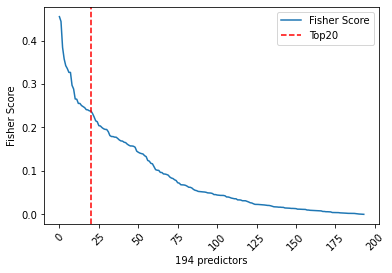

In [588]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

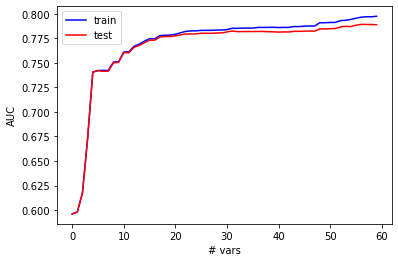

Wall time: 23.4 s


In [589]:
"""
Source: 
Phan, M. (2022). Statistical & Machine Learning. [Course]. Lille: IESEG Management School. MSc in Big Data Analytics.
"""
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 60
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, X_train[top_n_predictors], X_train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [590]:
# Select the top variables based on Fisher Score
n_top_fs_vars = 55  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 55


array(['pdays_bin_4', 'poutcome_remap_3', 'poutcome_remap_4',
       'emp.var.rate_bin_14', 'emp.var.rate_bin_13', 'contact_remap_3',
       'cons.price.idx_bin_21', 'cons.conf.idx_bin_20',
       'nr.employed_bin_8', 'previous_bin_4', 'emp.var.rate_bin_5',
       'nr.employed_bin_9', 'month_remap_12', 'cons.price.idx_bin_5',
       'emp.var.rate_bin_8', 'cons.conf.idx_bin_23', 'nr.employed_bin_6',
       'cons.conf.idx_bin_17', 'nr.employed_bin_7', 'previous_bin_3',
       'age_bin_50', 'default_remap_2', 'cons.conf.idx_bin_18',
       'cons.price.idx_bin_4', 'cons.conf.idx_bin_27', 'month_remap_10',
       'euribor3m_bin_8', 'euribor3m_bin_4', 'cons.price.idx_bin_19',
       'euribor3m_bin_6', 'month_remap_15', 'cons.conf.idx_bin_21',
       'cons.conf.idx_bin_13', 'cons.conf.idx_bin_15', 'euribor3m_bin_14',
       'cons.price.idx_bin_11', 'job_remap_4', 'euribor3m_bin_62',
       'cons.conf.idx_bin_11', 'cons.price.idx_bin_20', 'month_remap_16',
       'cons.price.idx_bin_24', 'cons

## 3. Modeling 

In [591]:
# Set here Variables to use in modeling
# we can choose whether we want to use fisher score variables or all the predictors. 
used_vars = top_fs_vars

In [592]:
def performance(model, printname):
    """
    This function returns the performance of AUC and Accuracy for the specified model.
    "model" represents the name of the model function, and "printname" is a string to give the model a name in the overview table. 
    """
    np.random.seed(1)
    #Train
    result = {}
    predictions   = model.predict(X_train[used_vars])
    probabilities = pd.DataFrame(model.predict_proba(X_train[used_vars]))[1]
    accuracy      = accuracy_score(y_train, predictions)
    auc           = roc_auc_score(np.array(y_train),np.array(probabilities))
    result[str(printname)] = {"Train_Accuracy":accuracy, "Train_AUC":auc}
    train_perf = pd.DataFrame(result).transpose()

    #Test
    result = {}
    predictions   = model.predict(X_test[used_vars])
    probabilities = pd.DataFrame(model.predict_proba(X_test[used_vars]))[1]
    accuracy      = accuracy_score(y_test, predictions)
    auc           = roc_auc_score(np.array(y_test),np.array(probabilities))
    result[str(printname)] = {"Test_Accuracy":accuracy,"Test_AUC":auc}
    test_perf = pd.DataFrame(result).transpose()

    #Compare Train and Test AUC
    perf_total = train_perf.merge(test_perf, left_index=True, right_index=True)
    return(perf_total)

#### 3.1 Simple Models (Without Gridsearch and Cross-Validation)  

In [593]:
# Fit Logistic Regression
np.random.seed(1)
lr=LogisticRegression().fit(X_train[used_vars], y_train)
lr_perf = performance(lr, 'Logistic Regression')


In [594]:
# Fit Random Forest
np.random.seed(1)
rf=RandomForestClassifier().fit(X_train[used_vars], y_train.values.ravel())
rf_perf = performance(rf, 'Random Forest')

In [595]:
# Fit Gradient Boosting
np.random.seed(1)
xgbc =GradientBoostingClassifier().fit(X_train[used_vars], y_train)
xgbc_perf = performance(xgbc, 'Gradient Boosting')

In [596]:
# Fit KNN
np.random.seed(1)
knn =KNeighborsClassifier().fit(X_train[used_vars], y_train)
knn_perf = performance(knn, 'KNN')

In [597]:
# Fit SVM
np.random.seed(1)
svm =SVC(probability=True).fit(X_train[used_vars], y_train)
svm_perf = performance(svm, 'SVM')

Overview

In [598]:
# Full performance
perf_overview = pd.concat([xgbc_perf, rf_perf, lr_perf, knn_perf, svm_perf]).sort_values(by="Test_AUC", ascending=False)
perf_overview

,Train_AUC,Train_Accuracy,Test_AUC,Test_Accuracy
Logistic Regression,0.793496,0.900438,0.801217,0.90025
Gradient Boosting,0.799968,0.904500,0.801207,0.90125
Random Forest,0.838477,0.919687,0.783546,0.89525
KNN,0.779126,0.905312,0.750977,0.89525
SVM,0.705586,0.905250,0.681501,0.90225


#### Interpretation of Logistic Regression 


In [599]:
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

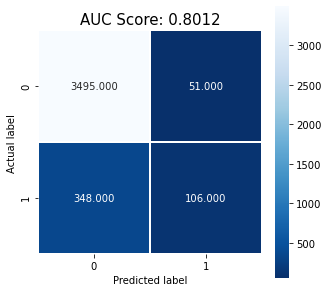

In [600]:
predictions = lr.predict(X_test[used_vars])
probabilities = pd.DataFrame(lr.predict_proba(X_test[used_vars]))[1]
auc         = roc_auc_score(np.array(y_test),np.array(probabilities))

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'AUC Score: {0}'.format(np.round(auc,4))
plt.title(all_sample_title, size = 15);

In [601]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc

In [602]:
y_score = lr.predict_proba(X_test[used_vars])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

### 3.2 Hyperparameter Tuning
We choose to perform Hyperparams on Logistic, Gradient Boosting, and Random Forest

#### (a) Logistic Regression 

In [603]:
#np.random.seed(1)

#Set a Parameter Space
# space={"C":np.logspace(-4, 4, 50),
#     "penalty":["l1", "l2"]} # l1 lasso l2 ridge

#Grid Search
#gs=GridSearchCV(LogisticRegression(), space, cv=10)

# Fit Model
#lr_gs = gs.fit(X_train[used_vars],y_train)

#Show performance
#print('Config: %s' % lr_gs.best_params_)
#lr_gs_perf = performance(lr_gs, 'Logistic Regression GS')
#lr_gs_perf

In [604]:
# Fit Logistic Regression
np.random.seed(1)
lr_gs=LogisticRegression(C = 0.019306977288832496, penalty = 'l2').fit(X_train[used_vars], y_train)
lr_gs_perf = performance(lr_gs, 'Logistic Regression GS')

In [605]:
# Logistic 2
np.random.seed(1)
lr_gs2=LogisticRegression(C= 0.2442053094548655, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_gs2 = performance(lr_gs2, 'Logistic Regression GS2')

In [606]:
# Logistic 3
np.random.seed(1)
lr_gs3=LogisticRegression(C= 0.09651957137350628, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_gs3 = performance(lr_gs3, 'Logistic Regression GS3')

In [607]:
#Logistic Nour 1
np.random.seed(1)
lr_nour1=LogisticRegression(C= 46.41588833612777, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour1 = performance(lr_nour1, 'Logistic Regression N1')

In [608]:
#Logistic Nour 2
np.random.seed(1)
lr_nour2=LogisticRegression(C= 40960000.0, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour2 = performance(lr_nour2, 'Logistic Regression N2')

In [609]:
#Logistic Nour 3
np.random.seed(1)
lr_nour3=LogisticRegression(C= 62.505519252739695, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour3 = performance(lr_nour3, 'Logistic Regression N3')

In [610]:
#Logistic Nour 4
np.random.seed(1)
lr_nour4=LogisticRegression(C=  1.2589254117941673, penalty= 'l2', solver = 'newton-cg').fit(X_train[used_vars], y_train)
lr_perf_nour4 = performance(lr_nour4, 'Logistic Regression N4')

In [611]:
#Logistic Nour 5
np.random.seed(1)
lr_nour5 = LogisticRegression(C=  11.513953993264476, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour5 = performance(lr_nour5, 'Logistic Regression N5')

In [612]:
#Logistic Nour 6
np.random.seed(1)
lr_nour6=LogisticRegression(C=  1e+20, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour6 = performance(lr_nour6, 'Logistic Regression N6')

In [613]:
#Logistic Nour 7
np.random.seed(1)
lr_nour7=LogisticRegression(C=  640884341.8931684, penalty= 'l2', solver = 'lbfgs').fit(X_train[used_vars], y_train)
lr_perf_nour7 = performance(lr_nour7, 'Logistic Regression N7')

In [614]:
#Logistic Nour 8
np.random.seed(1)
lr_nour8=LogisticRegression(C=  2.3741612048163567, penalty= 'l1', solver = 'liblinear').fit(X_train[used_vars], y_train)
lr_perf_nour8 = performance(lr_nour8, 'Logistic Regression N8')

In [615]:
#Logistic Nour 9
np.random.seed(1)
lr_nour9=LogisticRegression(C=  1.2589254117941673, penalty= 'l1', solver = 'liblinear').fit(X_train[used_vars], y_train)
lr_perf_nour9 = performance(lr_nour9, 'Logistic Regression N9')

#### (b) Random Forest

In [616]:
#// Parameter Space taken from:
#// https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# # Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 50, num = 1)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]

# # Create the random space grid
# space = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

#Grid Search
#rf_gs = RandomizedSearchCV(RandomForestClassifier(), space, cv=5)
#results = rf_gs.fit(X_train[used_vars],y_train.values.ravel())

# report performance
#print('Config: %s' % results.best_params_)
#rf_gs_perf = performance(rf_gs, 'Random Forest GS')
#rf_gs_perf

In [617]:
# Random Forest 1
np.random.seed(1)
rf_gs=RandomForestClassifier(n_estimators = 579, 
                        min_samples_split = 10, 
                        min_samples_leaf = 4, 
                        max_features = 'auto', 
                        max_depth = 5, 
                        bootstrap = True).fit(X_train[used_vars], y_train.values.ravel())

# Show performance
rf_gs_perf = performance(rf_gs, 'Random Forest GS')

In [618]:
# Random Forest 2
np.random.seed(1)
rf_gs2=RandomForestClassifier(n_estimators = 500, 
                        criterion = 'entropy',
                        max_features = 'sqrt', 
                        max_depth = 5, 
                        bootstrap = True).fit(X_train[used_vars], y_train.values.ravel())

# Show performance
rf_gs2_perf = performance(rf_gs2, 'Random Forest GS2')

In [619]:
# Random Forest 3
np.random.seed(1)
rf_gs3=RandomForestClassifier(n_estimators = 1000, 
                        criterion = 'entropy',
                        max_features = 'auto', 
                        max_depth = 5).fit(X_train[used_vars], y_train.values.ravel())

# Show performance
rf_gs3_perf = performance(rf_gs3, 'Random Forest GS3')

In [620]:
# Random Forest 4
np.random.seed(1)
rf_gs4=RandomForestClassifier(n_estimators = 2000, 
                        criterion = 'entropy',
                        max_features = 'auto', 
                        max_depth = 5, 
                        bootstrap = True).fit(X_train[used_vars], y_train.values.ravel())

# Show performance
rf_gs4_perf = performance(rf_gs4, 'Random Forest GS4')

#### (c) Gradient Boosting

In [621]:
# space = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000]}

#np.random.seed(1)

# Grid Search
#xgbc_gs = RandomizedSearchCV(xgb.XGBClassifier(seed = 1), space, scoring='roc_auc', n_iter=25)

# Fit Model
#results = xgbc_gs.fit(X_train[used_vars],y_train.values.ravel())
    
# report performance
#print('Config: %s' % results.best_params_)
#xgbc_gs_perf = performance(xgbc_gs, 'Gradient Boost GS')
#xgbc_gs_perf

In [622]:
# Fit Gradient Boosting
np.random.seed(1)
xgbc_gs = xgb.XGBClassifier(subsample = 0.5, 
                                n_estimators = 100, 
                                max_depth = 10, 
                                learning_rate = 0.01, 
                                colsample_bytree = 0.8999999999999999, 
                                colsample_bylevel = 0.8999999999999999).fit(X_train[used_vars], y_train)

# Show performance
xgbc_gs_perf = performance(xgbc_gs, 'Gradient Boosting GS')

In [623]:
# Gradient Boosting 2
np.random.seed(1)
xgbc_gs2 = xgb.XGBClassifier(subsample = 0.7, 
                                n_estimators = 100, 
                                max_depth = 15, 
                                learning_rate = 0.01, 
                                colsample_bytree = 0.4, 
                                colsample_bylevel = 0.7).fit(X_train[used_vars], y_train)

# Show performance
xgbc_gs2_perf = performance(xgbc_gs2, 'Gradient Boosting GS2')

Hyerparam Grid Overview

In [624]:
# Full overview
perf_gs = pd.concat([perf_overview, xgbc_gs_perf, rf_gs_perf, lr_gs_perf, lr_perf_nour1, lr_perf_nour2,
                     rf_gs2_perf, lr_perf_nour3, lr_perf_nour4, rf_gs3_perf, xgbc_gs2_perf, rf_gs4_perf, 
                     xgbc_gs2_perf, lr_perf_gs2, lr_perf_gs3, lr_perf_nour5, lr_perf_nour6, lr_perf_nour7, 
                     lr_perf_nour8, lr_perf_nour9]).sort_values(by="Test_AUC", ascending=False)
perf_gs

,Train_AUC,Train_Accuracy,Test_AUC,Test_Accuracy
Logistic Regression N8,0.793659,0.900500,0.801578,0.90025
Logistic Regression N9,0.793211,0.900750,0.801551,0.90100
Logistic Regression N4,0.793595,0.900438,0.801447,0.90025
Logistic Regression N5,0.793965,0.900312,0.801273,0.90050
Logistic Regression,0.793496,0.900438,0.801217,0.90025
Gradient Boosting,0.799968,0.904500,0.801207,0.90125
Logistic Regression N1,0.793932,0.900500,0.801040,0.90050
Logistic Regression N3,0.794021,0.900438,0.800724,0.90050
Logistic Regression GS2,0.792774,0.900250,0.800490,0.90000
Logistic Regression N6,0.794175,0.900563,0.800293,0.90025


#### 3.3 K-fold Cross-Validation
We choose the top 6 models by Test AUC in order to cross-validate

In [625]:
def kfoldcv(classifier, table):
    """
    This Function will help us crossvalidate and add the mean AUC and 
    Standard Deviation to our table in order to compare later.
    """
    np.random.seed(1)
    #setup cross validation
    cv = RepeatedStratifiedKFold(n_splits=10)

    #Cross-validate model
    scores = cross_val_score(classifier, X_train[used_vars], 
                        y_train.values.ravel(), 
                        scoring='roc_auc', 
                        cv=cv, 
                        n_jobs=-1)
    # report performance
    table['CV_AUC'] = np.mean(scores)
    table['CV_SD'] = np.std(scores)

In [629]:
#Crossvalidate everything

#Original Models
kfoldcv(lr, lr_perf)
kfoldcv(xgbc, xgbc_perf)
kfoldcv(rf, rf_perf)
kfoldcv(knn, knn_perf)
kfoldcv(svm, knn_perf)

#Boosted Tree Grid Search
kfoldcv(xgbc_gs, xgbc_gs_perf)
kfoldcv(xgbc_gs2, xgbc_gs2_perf)

#Random Forest Grid Search
kfoldcv(rf_gs, rf_gs_perf)
kfoldcv(rf_gs2, rf_gs2_perf)
kfoldcv(rf_gs3, rf_gs3_perf)
kfoldcv(rf_gs4, rf_gs4_perf)

#Logistic Grid Search
kfoldcv(lr_gs, lr_gs_perf)
kfoldcv(lr_gs2, lr_perf_gs2)
kfoldcv(lr_gs2, lr_perf_gs3)
kfoldcv(lr_nour1, lr_perf_nour1)
kfoldcv(lr_nour2, lr_perf_nour2)
kfoldcv(lr_nour3, lr_perf_nour3)
kfoldcv(lr_nour4, lr_perf_nour4)
kfoldcv(lr_nour5, lr_perf_nour5)
kfoldcv(lr_nour6, lr_perf_nour6)
kfoldcv(lr_nour7, lr_perf_nour7)
kfoldcv(lr_nour8, lr_perf_nour8)
kfoldcv(lr_nour9, lr_perf_nour9)

In [630]:
#Visualization of Cross-Validation
perf_cv = pd.concat([xgbc_perf, rf_perf, lr_perf, knn_perf, svm_perf, 
                    xgbc_gs_perf, xgbc_gs2_perf, rf_gs_perf, 
                    lr_gs_perf, lr_perf_gs2, lr_perf_gs3, lr_perf_nour1, lr_perf_nour2,
                    lr_perf_nour3, lr_perf_nour4, lr_perf_nour5, lr_perf_nour6,
                    lr_perf_nour7, lr_perf_nour8, lr_perf_nour9, 
                    rf_gs2_perf, rf_gs3_perf, rf_gs4_perf]).sort_values(by="CV_AUC", ascending=False)

#### 3.3 Create New Train Set
We re-concatenate the whole train dataset to fit our models with more data.

In [631]:
#Create new training set 
new_train = pd.concat([X_train[used_vars], X_test[used_vars]])
new_target = pd.concat([y_train, y_test])

In [632]:
def new_perf(classifier, table):
    """
    This function returns the performance of AUC and Accuracy for the specified model.
    "model" represents the name of the model function, and "printname" is a string to give the model a name in the overview table. 
    """
    np.random.seed(1)

    probabilities = pd.DataFrame(classifier.predict_proba(new_train))[1]
    auc           = roc_auc_score(np.array(new_target),np.array(probabilities))
    table['New_Train_AUC'] = auc
    return table 


In [633]:
#Logistic Regression 
lr = LogisticRegression().fit(new_train, new_target)
lr_perf = new_perf(lr, lr_perf)

lr_gs=LogisticRegression(C = 0.019306977288832496, penalty = 'l2').fit(new_train, new_target)
lr_gs_perf = new_perf(lr, lr_gs_perf)

lr_gs2=LogisticRegression(C= 0.2442053094548655, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_gs2 = new_perf(lr_gs2, lr_perf_gs2)

lr_gs3=LogisticRegression(C= 0.09651957137350628, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_gs3 = new_perf(lr_gs3, lr_perf_gs3)

lr_nour1=LogisticRegression(C= 46.41588833612777, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour1 = new_perf(lr_nour1, lr_perf_nour1)

lr_nour2=LogisticRegression(C= 40960000.0, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour2 = new_perf(lr_nour2, lr_perf_nour2)

lr_nour3 = LogisticRegression(C= 62.505519252739695, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour3 = new_perf(lr_nour3, lr_perf_nour3)

lr_nour4 = LogisticRegression(C=  1.2589254117941673, penalty= 'l2', solver = 'newton-cg').fit(new_train, new_target)
lr_perf_nour4 = new_perf(lr_nour4, lr_perf_nour4)

lr_nour5 = LogisticRegression(C=  11.513953993264476, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour5 = new_perf(lr_nour5, lr_perf_nour5)

lr_nour6=LogisticRegression(C=  1e+20, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour6 = new_perf(lr_nour6, lr_perf_nour6)

lr_nour7=LogisticRegression(C=  640884341.8931684, penalty= 'l2', solver = 'lbfgs').fit(new_train, new_target)
lr_perf_nour7 = new_perf(lr_nour7, lr_perf_nour7)

lr_nour8 = LogisticRegression(C=  2.3741612048163567, penalty= 'l1', solver = 'liblinear').fit(new_train, new_target)
lr_perf_nour8 = new_perf(lr_nour8, lr_perf_nour8)

lr_nour9=LogisticRegression(C=  1.2589254117941673, penalty= 'l1', solver = 'liblinear').fit(new_train, new_target)
lr_perf_nour9 = new_perf(lr_nour9, lr_perf_nour9)

In [634]:
# Boosted Tree
xgbc = GradientBoostingClassifier().fit(new_train, new_target)
xgbc_perf = new_perf(xgbc, xgbc_perf)

xgbc_gs = xgb.XGBClassifier(subsample = 0.5, 
                                n_estimators = 100, 
                                max_depth = 10, 
                                learning_rate = 0.01, 
                                colsample_bytree = 0.8999999999999999, 
                                colsample_bylevel = 0.8999999999999999).fit(new_train, new_target)
xgbc_gs_perf = new_perf(xgbc_gs, xgbc_gs_perf)

xgbc_gs2 = xgb.XGBClassifier(subsample = 0.7, 
                                n_estimators = 100, 
                                max_depth = 15, 
                                learning_rate = 0.01, 
                                colsample_bytree = 0.4, 
                                colsample_bylevel = 0.7).fit(new_train, new_target)
xgbc_gs2_perf = new_perf(xgbc_gs2, xgbc_gs2_perf)

In [635]:
rf_gs=RandomForestClassifier(n_estimators = 579, 
                        min_samples_split = 10, 
                        min_samples_leaf = 4, 
                        max_features = 'auto', 
                        max_depth = 5, 
                        bootstrap = True).fit(new_train, new_target)
rf_gs_perf = new_perf(rf_gs, rf_gs_perf)

rf_gs2=RandomForestClassifier(n_estimators = 500, 
                        criterion = 'entropy',
                        max_features = 'sqrt', 
                        max_depth = 5, 
                        bootstrap = True).fit(new_train, new_target)
rf_gs2_perf = new_perf(rf_gs2, rf_gs2_perf)

rf_gs3=RandomForestClassifier(n_estimators = 1000, 
                        criterion = 'entropy',
                        max_features = 'auto', 
                        max_depth = 5).fit(new_train, new_target)
rf_gs3_perf = new_perf(rf_gs3, rf_gs3_perf)

rf_gs4=RandomForestClassifier(n_estimators = 2000, 
                        criterion = 'entropy',
                        max_features = 'auto', 
                        max_depth = 5, 
                        bootstrap = True).fit(new_train, new_target) 
rf_gs4_perf = new_perf(rf_gs4, rf_gs4_perf)


<ipython-input-635-f5033760e32a>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-635-f5033760e32a>:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-635-f5033760e32a>:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-635-f5033760e32a>:22: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



#### 3.4 Cross-Validate New Train AUC

In [636]:
def kfoldcv_new(classifier, table):
    """
    This Function will help us crossvalidate and add the mean AUC and 
    Standard Deviation to our table in order to compare later.
    """
    np.random.seed(1)
    #setup cross validation
    cv = RepeatedStratifiedKFold(n_splits=10)

    #Cross-validate model
    scores = cross_val_score(classifier, new_train, 
                        new_target, 
                        scoring='roc_auc', 
                        cv=cv, 
                        n_jobs=-1)
    # report performance
    table['New_CV_AUC'] = np.mean(scores)
    table['New_CV_SD'] = np.std(scores)

In [637]:
#Crossvalidate everything

#Original Models
kfoldcv_new(lr, lr_perf)
kfoldcv_new(xgbc, xgbc_perf)
kfoldcv_new(rf, rf_perf)
kfoldcv_new(knn, knn_perf)
kfoldcv_new(svm, knn_perf)

#Boosted Tree Grid Search
kfoldcv_new(xgbc_gs, xgbc_gs_perf)
kfoldcv_new(xgbc_gs2, xgbc_gs2_perf)

#Random Forest Grid Search
kfoldcv_new(rf_gs, rf_gs_perf)
kfoldcv_new(rf_gs2, rf_gs2_perf)
kfoldcv_new(rf_gs3, rf_gs3_perf)
kfoldcv_new(rf_gs4, rf_gs4_perf)

#Logistic Grid Search
kfoldcv_new(lr_gs, lr_gs_perf)
kfoldcv_new(lr_gs2, lr_perf_gs2)
kfoldcv_new(lr_gs2, lr_perf_gs3)
kfoldcv_new(lr_nour1, lr_perf_nour1)
kfoldcv_new(lr_nour2, lr_perf_nour2)
kfoldcv_new(lr_nour3, lr_perf_nour3)
kfoldcv_new(lr_nour4, lr_perf_nour4)
kfoldcv_new(lr_nour5, lr_perf_nour5)
kfoldcv_new(lr_nour6, lr_perf_nour6)
kfoldcv_new(lr_nour7, lr_perf_nour7)
kfoldcv_new(lr_nour8, lr_perf_nour8)
kfoldcv_new(lr_nour9, lr_perf_nour9)

In [638]:
#Visualization of final results
perf_cv_final = pd.concat([xgbc_perf, rf_perf, lr_perf,
                    xgbc_gs_perf, xgbc_gs2_perf, rf_gs_perf, 
                    lr_gs_perf, lr_perf_gs2, lr_perf_gs3, lr_perf_nour1, lr_perf_nour2,
                    lr_perf_nour3, lr_perf_nour4, lr_perf_nour5, lr_perf_nour6,
                    lr_perf_nour7, lr_perf_nour8, lr_perf_nour9, 
                    rf_gs2_perf, rf_gs3_perf, rf_gs4_perf]).sort_values(by="New_CV_AUC", ascending=False)
perf_cv_final

,Train_AUC,Train_Accuracy,Test_AUC,Test_Accuracy,CV_AUC,CV_SD,New_Train_AUC,New_CV_AUC,New_CV_SD
Logistic Regression N4,0.793595,0.900438,0.801447,0.90025,0.788581,0.019085,0.795647,0.791383,0.018620
Logistic Regression,0.793496,0.900438,0.801217,0.90025,0.788544,0.019078,0.795733,0.791376,0.018655
Logistic Regression N5,0.793965,0.900312,0.801273,0.90050,0.788252,0.019056,0.795973,0.791301,0.018584
Logistic Regression N8,0.793659,0.900500,0.801578,0.90025,0.788439,0.019046,0.795535,0.791266,0.018690
Logistic Regression N9,0.793211,0.900750,0.801551,0.90100,0.788589,0.019101,0.795143,0.791245,0.018705
Logistic Regression N1,0.793932,0.900500,0.801040,0.90050,0.788126,0.019074,0.795725,0.791202,0.018569
Logistic Regression N3,0.794021,0.900438,0.800724,0.90050,0.788122,0.019020,0.796021,0.791183,0.018594
Logistic Regression N7,0.794011,0.900625,0.799843,0.90025,0.788053,0.019090,0.795772,0.791179,0.018559
Logistic Regression N6,0.794175,0.900563,0.800293,0.90025,0.788061,0.019075,0.795759,0.791145,0.018573
Logistic Regression N2,0.794025,0.900563,0.799917,0.90025,0.788108,0.019060,0.796033,0.791139,0.018549


## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [639]:
#Prepare predictions for submission
probabilities = pd.DataFrame(lr.predict_proba(test[used_vars]))[1]
submission = pd.DataFrame(test['client_id'])
submission['subscribe'] = probabilities

#Export file
submission.to_csv(wd + "/data/submissions/lr.csv", index= False)

In [640]:
#Prepare predictions for submission
probabilities = pd.DataFrame(lr_nour2.predict_proba(test[used_vars]))[1]
submission = pd.DataFrame(test['client_id'])
submission['subscribe'] = probabilities

#Export file
submission.to_csv(wd + "/data/submissions/lrnour2.csv", index= False)

In [641]:
#Prepare predictions for submission
probabilities = pd.DataFrame(xgbc.predict_proba(test[used_vars]))[1]
submission = pd.DataFrame(test['client_id'])
submission['subscribe'] = probabilities

#Export file
submission.to_csv(wd + "/data/submissions/xgbc.csv", index= False)

In [642]:
#Prepare predictions for submission
probabilities = pd.DataFrame(lr_nour4.predict_proba(test[used_vars]))[1]
submission = pd.DataFrame(test['client_id'])
submission['subscribe'] = probabilities

#Export file
submission.to_csv(wd + "/data/submissions/lrnour4.csv", index= False)